In [1]:
# set auto reload imported modules
%load_ext autoreload
%autoreload 2

In [1]:
''' imports '''

# numpy for array handling
import numpy as np

# import pytorch core libs
import torch

import pickle

# audio playback widget
import IPython.display as ipd

#%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt


# add sample-rnn libs directory to path
import sys
sys.path.append('../melodyrnn/')

# import core sample-rnn model (inc. frame-lvl rnn and sample-lvl mlp)
from model import SampleRNN
from model import Predictor
from model import Generator

# wrapper for optimiser
from optim import gradient_clipping

# training criterion
from nn import sequence_nll_loss_bits

# import audio dataset management
#from dataset import SampleRNNDataset
from dataset import MelodyDataset

#from dataset import DataLoader
from dataset import MelodyDataLoader

from utils import build_audio


In [2]:
''' initialise models components '''

# model parameters
_frame_sizes = (4, 4, 4)
_n_rnn = 2
_dim = 256
_learn_h0 = True
_q_levels = 2**7 # 7-bit depth for MIDI notes
_weight_norm = True

# initialise sample-rnn model
model = SampleRNN(
    frame_sizes = _frame_sizes,
    n_rnn = _n_rnn,
    dim = _dim,
    learn_h0 = _learn_h0,
    q_levels = _q_levels,
    weight_norm = _weight_norm
)

# intitialise predictor model
predictor = Predictor(model)

generator = Generator(model)


../melodyrnn/nn.py:62: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init(chunk)


In [3]:
''' push to device '''

# get computing device
device = ("cuda" if torch.cuda.is_available() else "cpu")

# push models to device
model = model.to(device)
predictor = predictor.to(device)


In [4]:
''' init optimiser '''

# get model parameters
params = predictor.parameters()

# initialise optimiser
optimizer = gradient_clipping( torch.optim.Adam(params, lr = 1e-5) )
#optimizer = torch.optim.Adam(params)


In [5]:
''' init dataset '''

# directory path
#dir_path = '../data/MIDI/'
dir_path = '../data/midi-trans/'

# init dataset
dataset = MelodyDataset(
    dir_path,
    cache = False,
    #cache = True,
    ds = 10,
)

print(len(dataset))

200


In [204]:
# inspect dataset, force load into cache
for i in range(len(dataset)):
    print(dataset[i].shape[0])
    

10241
9626
11879
13108
10036
18023
7169
11879
6964
20481
13108
22938
20276
19252
16660
10241
12493
16282
12289
13927
17204
13415
6964
15975
13517
15361
14337
9626
9217
19252
15565
19969
11060
7066
12670
12289
6759
22529
7988
16385
16385
13005
11060
14337
12084
16385
13620
7169
25805
23143
11777
11367
8602
13108
13108
13517
6452
12903
17613
18433
14132
9831
19252
11265
12698
23348
18023
15156
17613
10241
20890
7988
10241
13108
17204
12596
8602
13927
9012
20071
6861
10241
16897
16794
20071
16385
14746
9831
12698
21505
18023
10241
15156
15463
12289
11469
13005
18433
10650
20071
7885
16385
13927
9012
7285
18023
17903
16385
17193
13108
11060
16794
10445
11206
13108
9217
16385
9831
7355
11138
12954
6452
9831
14151
9012
10144
13108
8618
9626
6964
11879
6964
14951
14541
12289
9524
7783
13108
10855
16385
23757
13927
22221
19457
11367
16517
11060
11879
23348
7802
6554
10241
11469
7578
15156
12698
15565
15156
7373
8193
12843
14337
13108
17204
12596
6042
10650
15565
10855
14746
16794
9626
19354
24

(2000,)


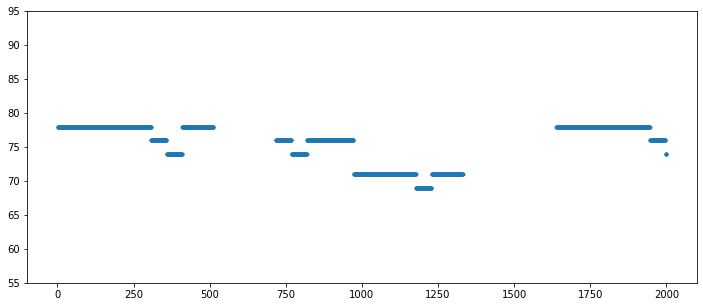

In [6]:
# quick display sample MIDI melody
plt.figure(figsize = (12, 5) )

m = dataset[0][:2000:]
print(m.shape)
plt.plot(m, '.')

plt.ylim(55,95)
plt.show()


In [7]:
# convert MIDI melody to audio, widget playback
m = dataset[0]

_pad = 32
M = np.zeros((128, m.shape[0]+_pad))
for i in range(m.shape[0]):
    if m[i] != 0:
        M[int(m[i]), _pad+i] = 1

sr = 16000
fr = (2**18 // 2) * 10

audio = build_audio(M, sr = sr, fr = fr, soft = 1e-4)

# normalise audio
audio /= audio.max()

# display playback widget
ipd.Audio(audio, rate = sr)


In [8]:
''' init dataloader '''

def collate(samples: list):
    
    ''' pad and collate list tracks for batch '''
    
    #print(samples[0].shape)
    
    # get max length sample in batch
    s = max([ sample.shape[0] for sample in samples ])
    
    # pad each sample to max length on time axis
    samples = [ np.pad(sample, (0, s - sample.shape[0]))
               for sample in samples ]
    
    # stack mini-batch samples, adjust batch to index zero
    samples = np.stack(samples, axis = 1).transpose(1, 0)
    
    # return mini-batch as tensors
    return torch.LongTensor(samples)


_overlap_len = model.lookback
print('overlap_len ', _overlap_len)

# set training sequence length (moving window length)
#_seq_len = 1024
#_seq_len = 512
_seq_len = 64

# set training batch size
_batch_size = 32

# intitialise dataloader
train_data_loader = MelodyDataLoader(
    dataset,
    batch_size = _batch_size,
    seq_len = _seq_len,
    overlap_len = _overlap_len,
    
    num_workers = 4,
    shuffle = True,
    
    collate_fn = collate,
    drop_last = True,
)


overlap_len  64


In [229]:
''' model training loop '''

# set training epochs
epochs = 10

# perform training model over epochs, iterate over range epoch limit
for _epoch in range(epochs):

    print('epoch: ', _epoch)
    
    ## model training, given dataset compute loss and update model parameters
    
    # set model to training mode (gradients stored)
    predictor.train()
    
    # iterate over dataset
    for (_iteration, data) in enumerate(train_data_loader):

        #print('iteration: ', _iteration)
        
        # zero gradients and step optimiser
        optimizer.zero_grad()

        # unpack dataset
        batch_inputs = data[0].to(device)
        batch_target = data[-1].to(device)
        
        #print(batch_inputs.shape)
        #print(batch_target.shape)
        
        # reevaluate the function multiple times; clear the gradients, compute and return loss
        def closure():

            # pass inputs through model, return output
            batch_output = predictor(batch_inputs, reset = data[1])
            #batch_output = predictor(batch_inputs, reset = False)

            # calculate loss for inputs to outputs
            loss = sequence_nll_loss_bits(batch_output, batch_target)

            #print(loss.item())

            # calculate gradients and return loss
            loss.backward()

            return loss

        # step optimiser with closure
        optimizer.step(closure)


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9


In [230]:
''' save checkpoint '''

torch.save(model.state_dict(), '../data/melody-state-new-trans-02')


In [9]:
''' load checkpoint '''

#_state_dict = torch.load('../data/chkpt')
_state_dict = torch.load('../data/melody-state-new-trans-02', map_location='cpu')

model.load_state_dict(_state_dict)


<All keys matched successfully>

In [12]:
''' init generator '''

generator = Generator(model)


In [9]:
# for generation excl. CUDA
if False:
    model.to('cpu')
    model.cuda = False

SampleRNN(
  (frame_level_rnns): ModuleList(
    (0): FrameLevelRNN(
      (input_expand): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (rnn): GRU(256, 256, num_layers=2, batch_first=True)
      (upsampling): LearnedUpsampling1d(
        (conv_t): ConvTranspose1d(256, 256, kernel_size=(4,), stride=(4,), bias=False)
      )
    )
    (1): FrameLevelRNN(
      (input_expand): Conv1d(16, 256, kernel_size=(1,), stride=(1,))
      (rnn): GRU(256, 256, num_layers=2, batch_first=True)
      (upsampling): LearnedUpsampling1d(
        (conv_t): ConvTranspose1d(256, 256, kernel_size=(4,), stride=(4,), bias=False)
      )
    )
    (2): FrameLevelRNN(
      (input_expand): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (rnn): GRU(256, 256, num_layers=2, batch_first=True)
      (upsampling): LearnedUpsampling1d(
        (conv_t): ConvTranspose1d(256, 256, kernel_size=(4,), stride=(4,), bias=False)
      )
    )
  )
  (sample_level_mlp): SampleLevelMLP(
    (embedding): Embedding(128, 

In [13]:
''' perform sample generation '''

#_n_samples = 1024
_n_samples = 1

#_sample_length = int(100000) # ~30s
#_sample_length = int( 10000 )
_sample_length = int( 15000 )

# generate samples
samples = generator(_n_samples, _sample_length).cpu().float().numpy()


../melodyrnn/model.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  prev_samples = torch.autograd.Variable(
../melodyrnn/model.py:183: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x.view(-1, self.q_levels)) \


In [35]:
''' save some generated samples '''

import pickle 

with open('../data/melody/smpls-new-trans-02', 'wb') as file:
    pickle.dump(samples, file)
    

In [5]:
''' load some generated samples '''

import pickle 

with open('../data/melody/smpls-new-trans-01', 'rb') as file:
    samples = pickle.load(file)
    

In [304]:
200*64

12800

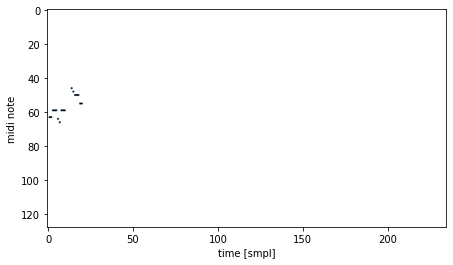

In [16]:
''' convert output to note matrix '''

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

# set downsample time axis [int]
ds = 64


i = 0

#for i in range(len(samples)):
    
m = samples[i]
_pad = 32
M = np.zeros((128, m.shape[0]+_pad))
for i in range(m.shape[0]):
    if m[i] != 0:
        M[int(m[i]), _pad+i] = 1


# display track note matrix
plt.imshow(M[::-1,::ds], cmap = 'bone_r', alpha = 1.)

# format figure and display
#ax.set_ylim(35, 95)

ax.set_ylabel('midi note')
ax.set_xlabel('time [smpl]')

plt.show()


In [17]:
''' build and play audio sample '''

# set sample rate
sr = 16000

# set frame rate of midi track, adjust for playback speed
fr = (2**18 * 10) // 2

# generate audio each track
audio = build_audio(M[:, :], sr = sr, fr = fr, soft = 1e-4)

# normalise audio
audio /= audio.max()

# display playback widget
ipd.Audio(audio, rate = sr)
